# MAMP with PB high level search and tube-based low level search

In [1]:
import sys
sys.path.append('../')

sys.path.append('../../')


from panav.env import NavigationEnv, Box2DRegion, PolygonRegion, box_2d_center, line_seg_to_obstacle
from panav.viz import draw_env
from panav.SAMP import Tube_Planning, SA_MILP_Planning
from panav.util import interpolate_positions, unique_tx
from panav.PBS.PBS import PBS
from panav.PBS.conflict import MA_plan_conflict


from panav.viz import animation
from IPython.display import HTML, display

import shapely
import numpy as np
from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 2

# The environment

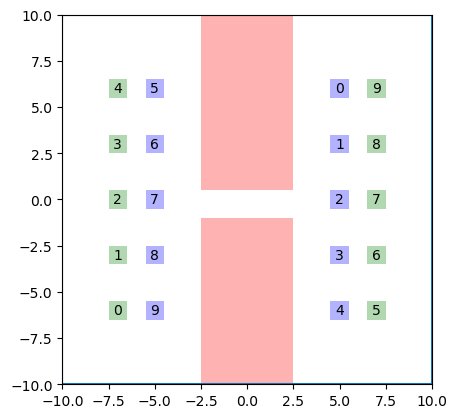

In [60]:
top, bottom = 6,-6
start_x_offset = 5 
goal_x_offset = 7
N = 5

start_locs = np.vstack([
np.vstack([np.ones(N)*start_x_offset,np.linspace(top,bottom, N)]).T,
np.vstack([np.ones(N)*(-start_x_offset),np.linspace(top,bottom, N)]).T])

goal_locs = np.vstack([
np.vstack([np.ones(N)*(-goal_x_offset),np.linspace(bottom,top, N)]).T,
np.vstack([np.ones(N)*goal_x_offset,np.linspace(bottom,top, N)]).T])


start_box_side = np.array([1,1])
goal_box_side = np.array([1,1])


starts = [box_2d_center(s,start_box_side) for s in start_locs]
goals = [box_2d_center(g,goal_box_side) for g in goal_locs]

O1 = Box2DRegion((-2.5,2.5),(0.5,10))
O2 = Box2DRegion((-2.5,2.5),(-10,-1.0))


limits = [(-10.0,10.0),(-10.0,10.0)]

bloating_r = 0.5 

env = NavigationEnv(limits,[O1,O2],starts,goals)

draw_env(env,[])

# Planning parameters

In [74]:
bloating_r = 0.5
d = 2
K = 7
t0 = 0
vmax = 1.0


# Planning with fixed-priority conflict resolution

## Using Tube-based planning as the low level

In [94]:
%%time

agents = set(np.arange(len(env.starts)))
plan = []
for agent in agents:
    print(agent)
    start = env.starts[agent]
    goal = env.goals[agent]

    t, xs = Tube_Planning(env,start,goal,vmax,bloating_r,\
                                 plan,\
                                d,K,t0)
    t,xs = unique_tx(t,xs)
    plan.append((t,xs))

0
1
2
3
4
5
6
7
8
9
CPU times: user 34min 11s, sys: 5min 21s, total: 39min 32s
Wall time: 6min 34s


In [95]:
print('flowtime:', np.sum([t[-1] for t,xs in plan]))

flowtime: 305.40572612117546


## Using temporary-obstacle-based planning as the low level

In [92]:
%%time

agents = set(np.arange(len(env.starts)))
plan = []
temp_obstacles = []
for agent in agents:
    print(agent)
    start = env.starts[agent]
    goal = env.goals[agent]

    t, xs = SA_MILP_Planning(env,start,goal,vmax,bloating_r,\
                                 temp_obstacles,\
                                d,K,t0)
    t,xs = unique_tx(t,xs)
    # Convert the agent's path into temporary obstacle.
    for k in range(xs.shape[-1]-1):
        temp_obstacles.append(([t[k],t[k+1]], 
                               line_seg_to_obstacle(xs[:,k],xs[:,k+1],bloating_r)))
    
    plan.append((t,xs))

0

Interrupt request received
1
2
3
4
5
6
7
8
9
CPU times: user 45.1 s, sys: 20.9 s, total: 1min 5s
Wall time: 12.4 s


In [93]:
print('flowtime:', np.sum([t[-1] for t,xs in plan]))

flowtime: 612.1513158622939


# Planning with PBS

In [69]:
import networkx as nx
prev_ordering = [(2, 0), (3, 0), (5, 0)]
new_order = [(3,0)]
graph = nx.DiGraph(prev_ordering+new_order)

In [88]:
%%time

metric = 'flowtime'
search_type = 'depth_first'

max_iter = 200

# solution,cost = PBS(env,vmax,bloating_r,d,K,t0,\
#                     max_iter,metric,search_type)


solution,cost = PBS(env,vmax,bloating_r,d,K,t0,\
                    max_iter,metric,search_type,
                    low_level = 'SA_MILP_Planning')


Interrupt request received


/Users/tianpengzhang/opt/miniconda3/envs/PA-Nav/lib/python3.11/site-packages/cvxpy/problems/problem.py:1391: UserWarning: 
    The problem is either infeasible or unbounded, but the solver
    cannot tell which. Disable any solver-specific presolve methods
    and re-solve to determine the precise problem status.

    For GUROBI and CPLEX you can automatically perform this re-solve
    with the keyword argument prob.solve(reoptimize=True, ...).
    
  warnings.warn(INF_OR_UNB_MESSAGE)


SolverError: Solver 'GUROBI' failed. Try another solver, or solve with verbose=True for more information.

In [89]:
print('flowtime:', np.sum([t[-1] for t,x in solution]))

flowtime: 188.05493701359237


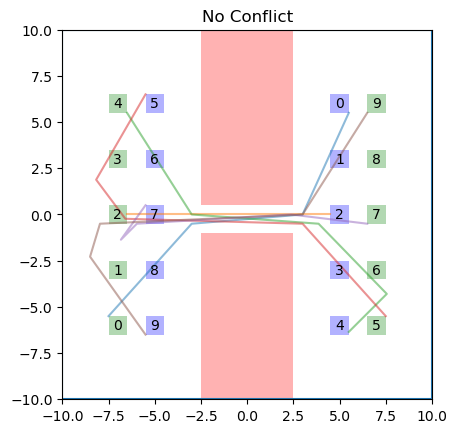

In [90]:

draw_env(env,[x for t,x in solution])

plt.title('Conflict' if MA_plan_conflict(solution,bloating_r)
 else 'No Conflict')

plt.show()

In [91]:
import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 2**128

interp_dt = 0.1
pos = []

for t,x in solution:
    t,x = interpolate_positions(t,x,interp_dt)
    pos.append(x)

anim = animation(env, pos, bloating_r, dt = interp_dt / 4)
display(HTML(anim.to_jshtml()))
plt.close()   # Avoid plotting an extra figure.

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x12ec8ad40> (for post_execute):


KeyboardInterrupt: 